
---
**FIRST SETUP**

In [1]:
!pip install -q kaggle
from google.colab import files

# Create a Kaggle API token and save it to a file.
!echo '{"username":"barelheby","key":"978bdd6cd1cc991c69bbe920fe75a9cc"}' > kaggle.json

# Copy the Kaggle API token file to the correct location.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

# Change the permissions of the Kaggle API token file.
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset.
!unzip chest-xray-pneumonia.zip

# Print the contents of the current working directory.
!ls


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

---
**IMPORTS**

In [2]:
import pandas as pd
from os.path import join
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet152
from keras.layers import BatchNormalization,Dropout,Dense,Flatten
from tensorflow.keras.optimizers import Adamax,Adam
import os
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.manifold import TSNE




---
 **Configuration**


In [3]:
TF_BATCH_SIZE = 32
TF_SEED = 123
IMG_HEIGHT = 256
IMG_WIDTH = 256
DIR_DATASET = "/content/chest_xray"

---
**Normalize Image Function**



---

**Training Set Preprocess**

In [4]:
train_directory = join(DIR_DATASET,"train")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


---

**Validation Set Prep**

In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [ ]:
train_dataset.class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
# train_dataset = train_dataset.map(lambda x,y:(x/255.0,y))
# validation_dataset = validation_dataset.map(lambda x,y:(x/255.0,y))

---
**Part 1 Model**

In [6]:
base_network = VGG16(weights="imagenet",include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
model_assigment_1  = Sequential(name="Assigment_1")
model_assigment_1.add(base_network)
model_assigment_1.add(Flatten())
model_assigment_1.add(Dense(512,activation="relu"))
model_assigment_1.add(Dropout(0.50))
model_assigment_1.add(Dense(128,activation="relu"))
model_assigment_1.add(Dropout(0.25))
model_assigment_1.add(Dense(60,activation="relu"))
model_assigment_1.add(Dense(1,activation="sigmoid"))
model_assigment_1.compile(optimizer=Adam(),loss='binary_crossentropy', metrics=['accuracy'])
model_assigment_1.summary()

Model: "Assigment_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model_assigment_1.fit(train_dataset,
                        epochs= 20,
                        validation_data = validation_dataset,
                        callbacks = early_stopping)

Epoch 1/20
131/131 [==============================] - 85s 503ms/step - loss: 0.3210 - accuracy: 0.8816 - val_loss: 0.1749 - val_accuracy: 0.9434
Epoch 2/20
131/131 [==============================] - 41s 300ms/step - loss: 0.1707 - accuracy: 0.9336 - val_loss: 0.1023 - val_accuracy: 0.9655
Epoch 3/20
131/131 [==============================] - 46s 338ms/step - loss: 0.1338 - accuracy: 0.9478 - val_loss: 0.1140 - val_accuracy: 0.9588
Epoch 4/20
131/131 [==============================] - 40s 294ms/step - loss: 0.1226 - accuracy: 0.9533 - val_loss: 0.1295 - val_accuracy: 0.9425
Epoch 5/20
131/131 [==============================] - 40s 290ms/step - loss: 0.1144 - accuracy: 0.9564 - val_loss: 0.0942 - val_accuracy: 0.9636
Epoch 6/20
131/131 [==============================] - 40s 295ms/step - loss: 0.0975 - accuracy: 0.9638 - val_loss: 0.0765 - val_accuracy: 0.9703
Epoch 7/20
131/131 [==============================] - 40s 291ms/step - loss: 0.0883 - accuracy: 0.9638 - val_loss: 0.0866 - val_ac

In [10]:
validation_loss, validation_accuracy = model_assigment_1.evaluate(validation_dataset)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

33/33 [==============================] - 9s 216ms/step - loss: 0.0707 - accuracy: 0.9760
Validation Loss: 0.0707080140709877
Validation Accuracy: 0.976030707359314


In [9]:
model_assigment_1.save("model_assigment_1.keras")

In [ ]:
DIR_ASS_2 = join(DIR_DATASET,"assiment_2_dataset")
DIR_ASS_2_BACTERIA  = join(DIR_ASS_2,"BACTERIA")
DIR_ASS_2_VIRUS = join(DIR_ASS_2,"VIRUS")
DIR_ASS_2_NORMAL = join(DIR_ASS_2,"NORMAL")


In [ ]:
try:
  shutil.rmtree(DIR_ASS_2)
except Exception as e:
  print(e)
try:
  os.mkdir(DIR_ASS_2)
  os.mkdir(DIR_ASS_2_BACTERIA)
  os.mkdir(DIR_ASS_2_VIRUS)
  os.mkdir(DIR_ASS_2_NORMAL)
except Exception as e:
  print(e)

[Errno 2] No such file or directory: '/content/chest_xray/assiment_2_dataset'


---
**Copy Images From Source To New Folder**

Copy sick

In [ ]:
# prompt: copy all files from DIR_DATASET/test/PNEUMONIA to DIR_DATASET/assigment_2_dataset
source_dir = join(DIR_DATASET,"train","PNEUMONIA")
for filename in os.listdir(source_dir):
  if "bacteria" in filename.lower():
    dest_dir  = DIR_ASS_2_BACTERIA
  elif "virus" in filename.lower():
    dest_dir = DIR_ASS_2_VIRUS
  else:
    pass
  shutil.copy(join(source_dir,filename),dest_dir)



Copy normal

In [ ]:
source_dir = join(DIR_DATASET,"train","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),DIR_ASS_2_NORMAL)

---
**Assigment 2 preprocess**

In [ ]:
train_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)
validation_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)

Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.


In [ ]:
train_dataset_ass_2.class_names

In [ ]:
# train_dataset_ass_2 = train_dataset_ass_2.map(lambda x,y:(x/255.0,y))
# validation_dataset_ass_2 = validation_dataset_ass_2.map(lambda x,y:(x/255.0,y))

In [ ]:
base_network_ass_2 = ResNet152(include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network_ass_2.trainable = False

234698864/234698864 [==============================] - 2s 0us/step


In [ ]:
model_assigment_2  = Sequential(name="Assigment_2")
model_assigment_2.add(base_network_ass_2)
# model_assigment_2.add(BatchNormalization())
# model_assigment_2.add(Flatten())
# model_assigment_2.add(Dense(512,activation="relu"))
model_assigment_2.add(Dense(1024,activation="relu"))
model_assigment_2.add(Dropout(0.3))
# model_assigment_2.add(BatchNormalization())
model_assigment_2.add(Dense(512,activation="relu"))
# model_assigment_2.add(Dense(256,activation="relu"))
model_assigment_2.add(Dropout(0.2))
# model_assigment_2.add(Dense(128,activation="relu"))
model_assigment_2.add(Dense(64,activation="relu"))
model_assigment_2.add(Dense(3,activation="softmax"))
model_assigment_2.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_assigment_2.summary()

Model: "Assigment_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 3)                 

In [ ]:
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
history_ass_2 = model_assigment_2.fit(train_dataset_ass_2,
                        epochs= 50,
                        validation_data = validation_dataset_ass_2,
                        callbacks = early_stopping)

Epoch 1/50
131/131 [==============================] - 80s 473ms/step - loss: 0.7158 - categorical_accuracy: 0.7033 - val_loss: 0.5433 - val_categorical_accuracy: 0.7785
Epoch 2/50
131/131 [==============================] - 50s 366ms/step - loss: 0.5095 - categorical_accuracy: 0.7764 - val_loss: 0.4759 - val_categorical_accuracy: 0.8006
Epoch 3/50
131/131 [==============================] - 49s 361ms/step - loss: 0.4871 - categorical_accuracy: 0.7872 - val_loss: 0.4811 - val_categorical_accuracy: 0.7939
Epoch 4/50
131/131 [==============================] - 49s 362ms/step - loss: 0.4671 - categorical_accuracy: 0.7994 - val_loss: 0.4883 - val_categorical_accuracy: 0.7862
Epoch 5/50
131/131 [==============================] - 49s 366ms/step - loss: 0.4515 - categorical_accuracy: 0.8133 - val_loss: 0.4550 - val_categorical_accuracy: 0.8102
Epoch 6/50
131/131 [==============================] - 49s 364ms/step - loss: 0.4342 - categorical_accuracy: 0.8172 - val_loss: 0.4886 - val_categorical_acc

In [ ]:
validation_loss, validation_accuracy = model_assigment_2.evaluate(validation_dataset_ass_2)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

In [ ]:
model_assigment_2.save("model_assigment_2.h5")

**Assigment 2**

---



Train The KNN Classifier Function

In [63]:
def train_knn_by_model(model,train_data):
  X_train = []
  y_train = []
  for batch, label in train_data:
      X_train.append(model.predict(batch))
      y_train.append(label)
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(X_train, y_train)
  return knn



Function To Classify New Image

In [64]:
def classify(new_image_path,model,knn_model,class_names,assigment_number):
  new_image = Image.open(new_image_path)
  new_image = new_image.resize((IMG_WIDTH,IMG_HEIGHT))
  new_image_array = np.array(new_image)
  new_image_array = np.expand_dims(new_image_array,axis=0)
  new_image_array = np.expand_dims(new_image_array,axis=-1)
  new_image_array = np.repeat(new_image_array, 3, axis=-1)
  new_image_tensor = tf.convert_to_tensor(new_image_array,tf.float32)
  # Create the embedding vector for the image
  new_image_embedding = model.predict(new_image_tensor)
  print("New Image Embedding",new_image_embedding)
  # Use knn to predict
  y_pred_knn = knn_model.predict(new_image_embedding)
  if assigment_number==1:
    return class_names[y_pred_knn[0]]
  y_pred_knn = y_pred_knn[0]
  for i in range(len(y_pred_knn)):
    if int(y_pred_knn[i])==1:
      return class_names[i]

Predict New Image - Assigment 1.a

---



In [ ]:
knn_model_ass_1 = train_knn_by_model(model_assigment_1,train_dataset)

In [ ]:
ass_1_class_names = ["NORMAL","PNEUMONIA"]
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_1,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_2,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_3 = "/content/chest_xray/test/NORMAL/IM-0043-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))

1/1 [==============================] - 0s 22ms/step
New Image Embedding [[1.]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 18ms/step
New Image Embedding [[0.9999639]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 19ms/step
New Image Embedding [[0.02433015]]
Expected: NORMAL, Got: NORMAL


Predict New Image Using KNN  

In [ ]:
knn_model_ass_2 = train_knn_by_model(model_assigment_2,train_dataset_ass_2)

1/1 [==============================] - 3s 3s/step


In [ ]:
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: BACTERIA, Got:", classify(img_1,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: VIRUS, Got:", classify(img_2,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_3 = "/content/chest_xray/test/NORMAL/IM-0011-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))

1/1 [==============================] - 1s 858ms/step
New Image Embedding [[9.2696357e-01 2.3935957e-06 7.3033988e-02]]
Expected: BACTERIA, Got: BACTERIA
1/1 [==============================] - 0s 37ms/step
New Image Embedding [[0.5186558  0.00390507 0.4774391 ]]
Expected: VIRUS, Got: VIRUS
1/1 [==============================] - 0s 38ms/step
New Image Embedding [[0.1604642  0.7407988  0.09873704]]
Expected: NORMAL, Got: NORMAL


Create Scatter Plots

In [ ]:
embeddings_1 = model_assigment_1.predict(train_dataset)


131/131 [==============================] - 34s 246ms/step


In [ ]:

tsne_data_1 = TSNE(n_components=1,perplexity=15)
tsne_data_1 = tsne_data_1.fit_transform(embeddings_1)
df_1 = pd.DataFrame(tsne_data_1, columns=["x"])
X_1 = df_1["x"]

y_names_1 = [validation_dataset.class_names[0 if row <0.5 else 1] for row in tsne_data_1]
fig_1 = px.scatter(df_1, color=y_names_1, opacity=0.8)
fig_1.show()


In [ ]:
embeddings_2 = model_assigment_2.predict(train_dataset_ass_2)

131/131 [==============================] - 40s 296ms/step


In [ ]:

tsne_data_2 = TSNE(n_components=3,perplexity=15).fit_transform(embeddings_2)
df = pd.DataFrame(tsne_data_2, columns=["x", "y", "z"])
X = df["x"]
y = df["y"]
z = df["z"]

y_names = [validation_dataset_ass_2.class_names[np.argmax(row)] for row in tsne_data_2]
fig = px.scatter(x=X, y=y,  color=y_names, opacity=0.8)
fig.show()


**Assigment 3**

In [ ]:
source_dir = join(DIR_DATASET,"train","NORMAL")
try:
  shutil.rmtree(join(DIR_DATASET,"train_directory_ass_3"))
except:
  pass
os.mkdir(join(DIR_DATASET,"train_directory_ass_3"))
os.mkdir(join(DIR_DATASET,"train_directory_ass_3","NORMAL"))
dest_dir = join(DIR_DATASET,"train_directory_ass_3","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),dest_dir)
train_directory_ass_3 = join(DIR_DATASET,"train_directory_ass_3")

source_dir = join(DIR_DATASET,"train","PNEUMONIA")
try:
  shutil.rmtree(join(DIR_DATASET,"train_directory_ass_3_pneumonia"))
except:
  pass
os.mkdir(join(DIR_DATASET,"train_directory_ass_3_pneumonia"))
os.mkdir(join(DIR_DATASET,"train_directory_ass_3_pneumonia","PNEUMONIA"))
dest_dir = join(DIR_DATASET,"train_directory_ass_3_pneumonia","PNEUMONIA")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),dest_dir)
train_directory_ass_3_pneumonia = join(DIR_DATASET,"train_directory_ass_3_pneumonia")

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_data_ass_3 = datagen.flow_from_directory(train_directory_ass_3,
                                               target_size=(256,256),
                                               batch_size=32,
                                               class_mode="input",
                                               subset="training"
                                               )
val_directory_ass_3 = join(DIR_DATASET,"test")
val_data_ass_3 = datagen.flow_from_directory(val_directory_ass_3,
                                               target_size=(256,256),
                                               batch_size=32,
                                               class_mode="input"
                                               )
sick_dataset_ass_3 = tf.keras.utils.image_dataset_from_directory(join(train_directory_ass_3,"..","train_directory_ass_3_pneumonia"),
                                               image_size =(256,256),
                                               batch_size=32,
                                              #  label_mode ="binary"
                                               )

Found 1341 images belonging to 1 classes.
Found 624 images belonging to 2 classes.
Found 3875 files belonging to 1 classes.


In [ ]:
from keras.layers import Conv2D,UpSampling2D,Reshape,Input,MaxPooling2D,Conv2DTranspose
autoencoder   = Sequential(name="autoencoder_assigment_3")
autoencoder.add(Input((256,256,3)))
# Encoder
autoencoder.add(Conv2D(32,3,activation="relu",padding="same"))
autoencoder.add(MaxPooling2D(2,padding="same"))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(16,3,activation="relu",padding="same"))
autoencoder.add(MaxPooling2D(2,padding="same"))
# Decoder
autoencoder.add(Conv2D(16,3,activation="relu",padding="same"))
autoencoder.add(UpSampling2D(2))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(32,3,activation="relu",padding="same"))
autoencoder.add(UpSampling2D(2))
# Output
autoencoder.add(Conv2D(3,3,activation="sigmoid",padding="same"))

autoencoder.compile(optimizer="adam",loss='mse')
autoencoder.summary()

Model: "autoencoderr_assigment_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_ass_3 = autoencoder.fit(train_data_ass_3,
                        epochs= 20,
                        shuffle = True,
                        validation_data = val_data_ass_3,
                        callbacks = [early_stopping])

Epoch 1/20
42/42 [==============================] - 63s 1s/step - loss: 0.0406 - val_loss: 0.0086
Epoch 2/20
42/42 [==============================] - 58s 1s/step - loss: 0.0057 - val_loss: 0.0044
Epoch 3/20
42/42 [==============================] - 56s 1s/step - loss: 0.0037 - val_loss: 0.0054
Epoch 4/20
42/42 [==============================] - 56s 1s/step - loss: 0.0027 - val_loss: 0.0068
Epoch 5/20
42/42 [==============================] - 56s 1s/step - loss: 0.0022 - val_loss: 0.0065
Epoch 6/20
42/42 [==============================] - 55s 1s/step - loss: 0.0019 - val_loss: 0.0056
Epoch 7/20
42/42 [==============================] - 55s 1s/step - loss: 0.0017 - val_loss: 0.0052


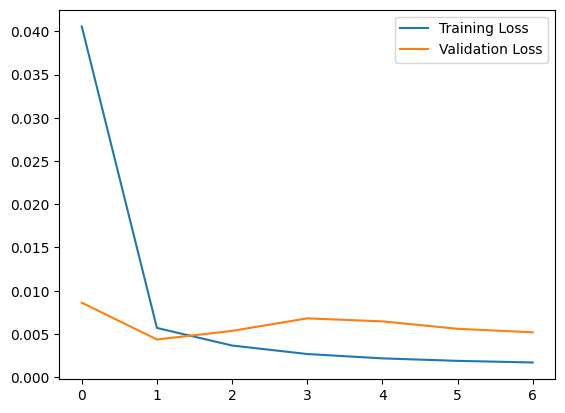

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_ass_3.history["loss"], label="Training Loss")
plt.plot(history_ass_3.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
autoencoder.save("ass_3.keras")

In [ ]:
import keras
autoencoder = keras.models.load_model('ass_3.keras')

In [ ]:
# prediction_test = autoencoder.predict(test_dataset)
prediction_train = autoencoder.predict(train_data_ass_3)

42/42 [==============================] - 40s 956ms/step


In [ ]:
threshold = 0
iterator = iter(train_data_ass_3)
for i in range (len(iterator)):
  try:
    val, lbl = next(iterator)
    train_loss = tf.keras.losses.mae(prediction_train[i], val[i])
    temp_threshold = np.mean(train_loss) + np.std(train_loss)
    threshold = temp_threshold if temp_threshold > threshold else threshold
  except:
    break
print("Threshold: ", threshold)

Threshold:  0.6619645


In [ ]:
def get_anomaly(model,data):
  pred = model.predict(data)
  loss = tf.keras.losses.mae(pred,data)
  test_th = np.mean(loss) + np.std(loss)
  return test_th

In [ ]:
d={
    "NORMAL":[],
    "PNEUMONIA":[]
}
for index,kind in enumerate([train_data_ass_3,sick_dataset_ass_3]):
  iterator =iter(kind)
  for i in range(len(kind)):
    val, lbl = next(iterator)
    anomaly = get_anomaly(autoencoder,val)
    # if anomaly > threshold:
      # classification = "PNEUMONIA"
    # else:
      # classification = "NORMAL"
    d["PNEUMONIA" if index==1 else "NORMAL"].append(anomaly)


1/1 [==============================] - 0s 26ms/step


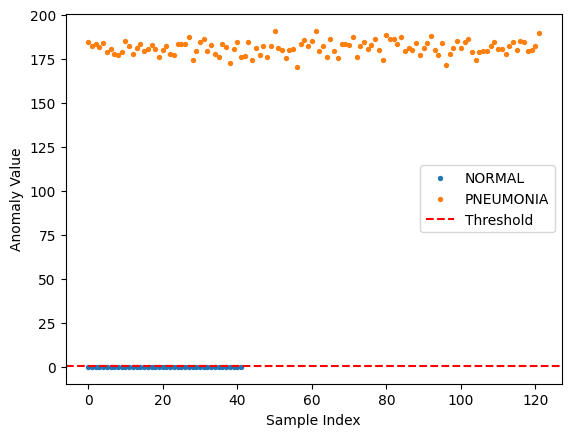

In [ ]:
fig, ax = plt.subplots()
normal_data = d["NORMAL"]
sick_data = d["PNEUMONIA"]
x_labels = range(len(normal_data))
sick_labels = range(len(sick_data))
ax.scatter(x_labels, normal_data, label="NORMAL",s=8)
ax.scatter(sick_labels, sick_data, label="PNEUMONIA",s=8)

ax.axhline(y=threshold, color='r', linestyle='--',label="Threshold")
ax.legend()
ax.set_ylabel("Anomaly Value")
ax.set_xlabel("Sample Index")
plt.show()

**Assigment 4 **

---



In [56]:
def get_image_tensor_from_image_path(image_path):
  new_image = Image.open(image_path)
  new_image = new_image.resize((IMG_WIDTH,IMG_HEIGHT))
  new_image_array = np.array(new_image)
  new_image_array = np.expand_dims(new_image_array,axis=0)
  new_image_array = np.expand_dims(new_image_array,axis=-1)
  new_image_array = np.repeat(new_image_array, 3, axis=-1)
  new_image_tensor = tf.convert_to_tensor(new_image_array,tf.float32)
  new_image_tensor = new_image_tensor.numpy()
  new_image_tensor = np.reshape(new_image_tensor,(IMG_WIDTH,IMG_HEIGHT,-1))/255.0
  return new_image_tensor

In [76]:
def explain_image(image,actual_classification,prediction_classification):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, lambda x: model.predict(x,verbose=0), top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Predicted - ' + prediction_classification + '\n Ground Truth - ' + actual_classification
             + ' \n Green Regions -> Supporting the predicted label \n Red Regions -> Against the predicted label')
    plt.show()

In [78]:
imgs = [
    {
        "type":"PNEUMONIA",
        "path":"/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
    },
    {
        "type":"NORMAL",
        "path":"/content/chest_xray/chest_xray/test/NORMAL/IM-0005-0001.jpeg"
    },
    {
        "type":"PNEUMONIA",
        "path":"/content/chest_xray/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg"
    },
    {
        "type":"PNEUMONIA",
        "path":"/content/chest_xray/chest_xray/test/PNEUMONIA/person140_bacteria_668.jpeg"
    }
]

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
model = load_model('model_assigment_1.keras')
knn_model_ass_1 = train_knn_by_model(model,train_dataset)
ass_1_class_names=["NORMAL","PNEUMONIA"]
# img_path = '/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg'
# img = get_image_tensor_from_image_path(img_path)

In [ ]:
for obj in imgs:
  tp = obj["type"]
  prediction = classify(obj["path"],model,knn_model_ass_1,ass_1_class_names,1)
  img = get_image_tensor_from_image_path(obj["path"])
  explain_image(img,tp,prediction)